In [1]:
import torch
import argparse
import yaml
import os
import os.path as osp
from model import build_model
from utils import *
import time

if __name__ == '__main__':
    config_path = 'D:/project/DashCam/MiniROAD/configs/miniroad_thumos_kinetics.yaml'
    ckpt_path = 'D:/project/DashCam/models/THUMOS_Kinetics.pth'
    opt = yaml.load(open(config_path), Loader=yaml.FullLoader)
    cfg = opt
    cfg['no_flow'] = False
    cfg['no_rgb'] = False

    set_seed(20)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    device = 'cpu'  # FORCING CPU FOR TESTING PURPOSES
    print(f"Sử dụng thiết bị: {device}")


    model = build_model(cfg, device)
    checkpoint_data = torch.load(ckpt_path, map_location=device)
    model.eval()
    print("Model đã sẵn sàng inference.")

    window_size = cfg['window_size']
    rgb_feature_dim = 2048
    flow_feature_dim = 1024
    feature_dim = rgb_feature_dim + flow_feature_dim # Concatenated
    
    batch_size = 1
    dummy_input = torch.randn(batch_size, window_size, feature_dim).to(device)
    rgb_dummy = dummy_input[:, :, :rgb_feature_dim]
    flow_dummy = dummy_input[:, :, rgb_feature_dim:]
    print(f"- Input Shape: {dummy_input.shape}")

    start_time = time.time()
    with torch.no_grad():
        output = model(rgb_dummy, flow_dummy) 
    end_time = time.time()
    print(f"Inference hoàn tất sau {end_time - start_time:.4f} giây.")

    print("\nKết quả Output:")
    if isinstance(output, torch.Tensor):
        print(f"- Shape: {output.shape}")
        # In giá trị đầu tiên của batch và time step cuối cùng
        # (Cần kiểm tra shape output cụ thể của model bạn build)
        try:
            if len(output.shape) == 3:
                 if output.shape[2] == window_size: # TCN? [B, C, T]
                     last_step_output = output[0, :, -1]
                     print(f"- Output tại step cuối (shape {last_step_output.shape}):")
                     print(last_step_output[:10].cpu().numpy()) # In 10 giá trị đầu
                 elif output.shape[1] == window_size: # GRU? [B, T, C]
                     last_step_output = output[0, -1, :]
                     print(f"- Output tại step cuối (shape {last_step_output.shape}):")
                     print(last_step_output[:10].cpu().numpy()) # In 10 giá trị đầu
            elif len(output.shape) == 2: # Trường hợp khác?
                 print(output[0,:10].cpu().numpy())
            else:
                 print(output)
                 
        except IndexError:
             print(output)
             
    elif isinstance(output, dict): # Nếu model trả về dict
         print("- Output là một dictionary:")
         for key, value in output.items():
             if isinstance(value, torch.Tensor):
                 print(f"  + Key '{key}': Shape {value.shape}")
             else:
                 print(f"  + Key '{key}': {value}")
    else:
        print(output)

Sử dụng thiết bị: cpu
Model đã sẵn sàng inference.
- Input Shape: torch.Size([1, 128, 3072])
Inference hoàn tất sau 0.0445 giây.

Kết quả Output:
- Output là một dictionary:
  + Key 'logits': Shape torch.Size([1, 128, 22])


In [2]:
import torch
import torch.nn as nn
import time
import torch.hub # <--- Dùng TorchHub

# Lớp Wrapper mới (Flatten + MLP)
class X3DFlattenExtractor(nn.Module):
    def __init__(self, original_x3d_model, target_feature_dim):
        super().__init__()
        # Giữ lại tất cả các block TRỪ block cuối cùng (head)
        self.feature_blocks = nn.Sequential(*original_x3d_model.blocks[:-1]) 
        
        # Xác định kích thước flatten (C*H*W)
        self._determine_flatten_size(original_x3d_model)
        
        # Thêm lớp MLP (Linear) để chiếu (project) về kích thước mong muốn
        if self.flatten_dim > 0:
            self.mlp = nn.Linear(self.flatten_dim, target_feature_dim)
            print(f"Đã thêm MLP: Linear({self.flatten_dim}, {target_feature_dim})")
        else:
            raise ValueError("Không thể xác định flatten_dim.")

    def _determine_flatten_size(self, original_model):
        """Chạy thử để lấy kích thước C, H, W trước head."""
        self.flatten_dim = 0
        try:
             temp_model = nn.Sequential(*original_model.blocks[:-1])
             temp_model.eval()
             # Lấy T, H, W từ model gốc hoặc dùng giá trị mặc định
             # (Cần khớp với model_name khi gọi load_... )
             T_in, H_in, W_in = 13, 182, 182 # Giả sử X3D-S
             dummy_input = torch.randn(1, 3, T_in, H_in, W_in)
             with torch.no_grad():
                  output_before_head = temp_model(dummy_input)
             # Shape: [B, C_out, T_out, H_out, W_out]
             B, C_out, T_out, H_out, W_out = output_before_head.shape
             self.flatten_dim = C_out * H_out * W_out
             print(f"Kích thước sau flatten (C*H*W): {self.flatten_dim} ({C_out}*{H_out}*{W_out})")
        except Exception as e:
             print(f"Lỗi khi xác định flatten_dim: {e}")

    def forward(self, x):
        # 1. Chạy qua các block gốc (0 đến 4)
        x = self.feature_blocks(x) 
        # Output shape ví dụ: [B, 192, 13, H_out, W_out] (e.g., [1, 192, 13, 6, 6])
        
        # 2. Permute để đưa T ra trước: [B, T, C, H, W]
        x = x.permute(0, 2, 1, 3, 4) 
        # Output shape ví dụ: [1, 13, 192, 6, 6]
        
        # 3. Flatten C, H, W
        B, T, C, H, W = x.shape
        x = x.reshape(B, T, -1) # Tự động tính C*H*W
        # Output shape ví dụ: [1, 13, 6912]
        
        # 4. Áp dụng MLP
        x = self.mlp(x)
        # Output shape ví dụ: [1, 13, target_feature_dim]
        
        return x

def load_x3d_flatten_extractor(model_name: str = 'x3d_s', pretrained: bool = True, target_feature_dim: int = 3072):
    """
    Tải model X3D từ PytorchVideo/TorchHub, flatten output trước head
    và thêm MLP để chiếu về target_feature_dim.
    """
    print(f"Đang tải model gốc: {model_name} (pretrained={pretrained})...")
    
    # 1. Tải model X3D gốc đầy đủ
    original_model = torch.hub.load(
        'facebookresearch/pytorchvideo', 
        model_name,                      
        pretrained=pretrained            
    )
    original_model.eval() 

    # 2. Tạo backbone mới bằng lớp Wrapper
    try:
        backbone = X3DFlattenExtractor(original_model, target_feature_dim)
        # Lấy T từ việc chạy thử (cần để test)
        if model_name == 'x3d_s': T_out = 128
        elif model_name == 'x3d_xs': T_out = 4
        else: T_out = 16 # M, L
            
        print("Đã tạo backbone (Flatten + MLP).")
        return backbone, target_feature_dim, T_out
    except ValueError as e:
        print(f"Lỗi khi tạo backbone: {e}")
        return None, 0, 0

# --- CÁCH SỬ DỤNG ---
if __name__ == '__main__':
    
    # *** ĐỊNH NGHĨA KÍCH THƯỚC FEATURE MONG MUỐN CỦA MINIROAD ***
    MINIROAD_INPUT_DIM = 3072 # Ví dụ: RGB(2048) + Flow(1024)
    # MINIROAD_INPUT_DIM = 192 # Hoặc nếu bạn muốn thử khớp với spatial pooling
    
    # Tải backbone X3D-S (Flatten + MLP)
    backbone, final_feature_dim, time_steps = load_x3d_flatten_extractor(
        model_name='x3d_s', 
        pretrained=True, 
        target_feature_dim=MINIROAD_INPUT_DIM 
    )
    
    if backbone:
        device = "cuda" if torch.cuda.is_available() else "cpu"
        backbone.to(device)
        backbone.eval()

        print(f"\n--- Thử nghiệm Backbone (X3D-S Flatten + MLP) ---")
        print(f"Model đang chạy trên: {device}")
        print(f"Kích thước đặc trưng mỗi bước thời gian (sau MLP): {final_feature_dim}") 
        print(f"Số bước thời gian trong output: {time_steps}") 

        # Input shape [B, C, T, H, W] (X3D-S)
        T_in, H_in, W_in = 128, 182, 182 
        dummy_clip = torch.randn(1, 3, T_in, H_in, W_in).to(device)
        print(f"Input shape (B, C, T, H, W): {dummy_clip.shape}")

        start_time = time.time()
        with torch.no_grad():
            features_sequence = backbone(dummy_clip) 
        end_time = time.time()

        print(f"Output shape (Features Sequence): {features_sequence.shape}") # Phải là [1, 13, MINIROAD_INPUT_DIM]
        print(f"Thời gian suy luận 1 clip: {end_time - start_time:.4f}s")
        
        # Kiểm tra shape đầu ra
        expected_shape = (1, time_steps, final_feature_dim)
        if features_sequence.shape == expected_shape:
             print(f"\nTest thành công! Shape đầu ra chính xác: {features_sequence.shape}")
        else:
             print(f"\nLỗi: Shape đầu ra không chính xác: {features_sequence.shape}. Mong đợi: {expected_shape}")

Đang tải model gốc: x3d_s (pretrained=True)...


Using cache found in C:\Users\hieuh/.cache\torch\hub\facebookresearch_pytorchvideo_main


Kích thước sau flatten (C*H*W): 6912 (192*6*6)
Đã thêm MLP: Linear(6912, 3072)
Đã tạo backbone (Flatten + MLP).

--- Thử nghiệm Backbone (X3D-S Flatten + MLP) ---
Model đang chạy trên: cuda
Kích thước đặc trưng mỗi bước thời gian (sau MLP): 3072
Số bước thời gian trong output: 128
Input shape (B, C, T, H, W): torch.Size([1, 3, 128, 182, 182])
Output shape (Features Sequence): torch.Size([1, 128, 3072])
Thời gian suy luận 1 clip: 0.0151s

Test thành công! Shape đầu ra chính xác: torch.Size([1, 128, 3072])


In [ ]:
import torch
import torch.nn as nn
import time
import torch.hub 
import queue 
import threading 
import cv2
from PIL import Image
import torchvision.transforms as transforms
from collections import deque
import argparse
import yaml
import os
import os.path as osp
from model import build_model # Từ repo MiniROAD
from utils import * # Từ repo MiniROAD

# --- Lớp Wrapper Backbone X3D (Từ câu trước) ---
class X3DFeatureExtractor(nn.Module):
    def __init__(self, original_x3d_model):
        super().__init__()
        self.feature_blocks = nn.Sequential(*original_x3d_model.blocks[:-1]) 
        self.spatial_pool = nn.AdaptiveAvgPool3d((None, 1, 1)) 

    def forward(self, x):
        x = self.feature_blocks(x) 
        x = self.spatial_pool(x)
        x = x.squeeze(-1).squeeze(-1) # -> [B, C, T]
        x = x.permute(0, 2, 1) # -> [B, T, C]
        return x

# --- Hàm Load Backbone X3D (Từ câu trước) ---
def load_x3d_feature_extractor(model_name: str = 'x3d_s', pretrained: bool = True):
    print(f"Đang tải model gốc X3D: {model_name}...")
    original_model = torch.hub.load(
        'facebookresearch/pytorchvideo', model_name, pretrained=pretrained
    )
    original_model.eval() 
    feature_dim = 0
    num_temporal_steps = 0
    try:
         temp_model = nn.Sequential(*original_model.blocks[:-1]) 
         temp_model.eval()
         if model_name == 'x3d_s': T, H, W = 128, 182, 182
         elif model_name == 'x3d_xs': T, H, W = 4, 160, 160
         else: T, H, W = 16, 224, 224 # M, L         
         dummy_input = torch.randn(1, 3, T, H, W)
         with torch.no_grad():
              output_before_head = temp_model(dummy_input)
         feature_dim = output_before_head.shape[1] 
         num_temporal_steps = output_before_head.shape[2] 
         print(f"X3D output trước head: [B, {feature_dim}, {num_temporal_steps}, H, W]")
    except Exception as e:
         print(f"Lỗi khi xác định feature_dim/T: {e}")
         return None, 0, 0
    if feature_dim == 0 or num_temporal_steps == 0: return None, 0, 0
    backbone = X3DFeatureExtractor(original_model)
    print("Đã tạo backbone X3D trích xuất chuỗi feature.")
    return backbone, feature_dim, num_temporal_steps 

# --- Hàm Preprocessor cho X3D (Từ câu trước) ---
def get_preprocessor_x3d(model_name='x3d_s'):
    if model_name == 'x3d_s': H, W = 182, 182
    elif model_name == 'x3d_xs': H, W = 160, 160
    else: H, W = 224, 224 # M, L
    MEAN = [0.45, 0.45, 0.45]
    STD = [0.225, 0.225, 0.225]
    return transforms.Compose([
        transforms.Resize((H, W)),
        transforms.ToTensor(),
        transforms.Normalize(mean=MEAN, std=STD)
    ])

# --- Luồng 1: Producer (Giữ nguyên) ---
def producer_thread(video_path: str, frame_queue: queue.Queue):
    print(f"[Producer] Bắt đầu đọc video: {video_path}")
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"[Producer] Lỗi: Không thể mở video {video_path}")
        frame_queue.put(None) # Gửi tín hiệu kết thúc sớm
        return
    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret: break
        frame_count += 1
        frame_queue.put(frame) 
    cap.release()
    frame_queue.put(None) 
    print(f"[Producer] Đã đọc {frame_count} frames. Kết thúc.")

# --- Luồng 2: Consumer (Gộp X3D + MLP + MiniROAD) ---
def consumer_thread(frame_queue: queue.Queue, miniroad_cfg: dict, miniroad_ckpt_path: str):
    
    print("[Consumer] Bắt đầu khởi tạo...")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"[Consumer] Sử dụng thiết bị: {device}")

    # --- 1. Tải Backbone X3D ---
    x3d_model_name = 'x3d_s' # Chọn model X3D
    backbone, x3d_feature_dim, x3d_time_steps = load_x3d_feature_extractor(
        model_name=x3d_model_name, pretrained=True
    )
    if backbone is None: return
    backbone.eval()
    backbone.to(device)
    for param in backbone.parameters(): param.requires_grad = False
    print(f"[Consumer] Backbone X3D ({x3d_model_name}) sẵn sàng. Output dim: {x3d_feature_dim}, Time steps: {x3d_time_steps}")

    # --- 2. Tải OAD Head MiniROAD ---
    print("[Consumer] Đang tải MiniROAD OAD Head...")
    oad_head = build_model(miniroad_cfg, device)
    checkpoint_data = torch.load(miniroad_ckpt_path, map_location=device)
    if isinstance(checkpoint_data, dict) and 'state_dict' in checkpoint_data:
        oad_head.load_state_dict(checkpoint_data['state_dict'])
    else:
        oad_head.load_state_dict(checkpoint_data)
    oad_head.eval()
    for param in oad_head.parameters(): param.requires_grad = False
    print("[Consumer] OAD Head MiniROAD sẵn sàng.")
    
    # --- 3. Xác định Kích thước Feature cho MiniROAD ---
    # Lấy từ config MiniROAD hoặc hardcode nếu biết chắc
    miniroad_window_size = miniroad_cfg.get('window_size', 128) # Lấy từ config, mặc định 128
    # Kích thước này PHẢI khớp với checkpoint đã load
    miniroad_expected_feature_dim = 3072 # Hardcode dựa trên output của bạn
    print(f"[Consumer] MiniROAD Head mong đợi input dim: {miniroad_expected_feature_dim}, Window: {miniroad_window_size}")

    # --- 4. Tạo MLP để chiếu Feature ---
    # Chiếu từ x3d_feature_dim (192) -> miniroad_expected_feature_dim (3072)
    mlp_projector = nn.Linear(x3d_feature_dim, miniroad_expected_feature_dim).to(device)
    mlp_projector.eval() # Không cần huấn luyện MLP này
    print(f"[Consumer] Đã tạo MLP Projector: Linear({x3d_feature_dim}, {miniroad_expected_feature_dim})")

    # --- 5. Chuẩn bị Pipeline & Buffers ---
    preprocessor = get_preprocessor_x3d(x3d_model_name)
    num_frames_per_x3d_chunk = x3d_time_steps # 13 frames cho X3D-S
    
    frame_buffer = [] # Gom frame cho X3D
    feature_buffer = deque(maxlen=miniroad_window_size) # Gom feature cho MiniROAD

    chunk_count = 0
    print("[Consumer] Bắt đầu vòng lặp E2E...")
    pipeline_start_time = time.time()
    total_frames_processed = 0
    
    while True:
        frame_bgr = frame_queue.get() 
        if frame_bgr is None: break
            
        img_pil = Image.fromarray(cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB))
        processed_frame = preprocessor(img_pil)
        frame_buffer.append(processed_frame)

        # --- Giai đoạn 1: Chạy Backbone X3D ---
        if len(frame_buffer) == num_frames_per_x3d_chunk:
            chunk_count += 1
            total_frames_processed += num_frames_per_x3d_chunk
            
            # Stack frames [13, 3, H, W]
            segment = torch.stack(frame_buffer, dim=0) 
            # Permute & Add Batch [1, 3, 13, H, W]
            segment_batch = segment.permute(1, 0, 2, 3).unsqueeze(0).to(device) 

            with torch.no_grad():
                # Chạy X3D -> output [1, 13, 192] (B, T, C)
                x3d_features_sequence = backbone(segment_batch) 
                # Chạy MLP -> output [1, 13, 3072] (B, T, D_out)
                projected_features_sequence = mlp_projector(x3d_features_sequence)

            frame_buffer = [] # Xóa buffer frame

            # Thêm TỪNG feature trong chuỗi vào buffer feature
            # projected_features_sequence.squeeze(0) -> [13, 3072]
            for feature_vec in projected_features_sequence.squeeze(0):
                feature_buffer.append(feature_vec) # Thêm tensor [3072]

        # --- Giai đoạn 2: Chạy OAD Head MiniROAD ---
        # Chỉ chạy khi Buffer feature đã đầy
        if len(feature_buffer) == miniroad_window_size:
            start_oad = time.time()
            
            # Stack features: list(deque) -> 128 x [3072]
            # feature_sequence shape: [128, 3072]
            feature_sequence = torch.stack(list(feature_buffer), dim=0)
            
            # Thêm chiều Batch: [1, 128, 3072]
            feature_sequence_batch = feature_sequence.unsqueeze(0)
            
            # Chuẩn bị input cho MiniROAD (có thể cần tách RGB/Flow giả)
            # Dựa vào code test trước đó, model nhận (rgb, flow)
            # Chúng ta tạo rgb_dummy và flow_dummy từ feature đã project
            # Giả sử 2048 đầu là RGB, 1024 sau là Flow
            rgb_dummy_input = feature_sequence_batch[:, :, :2048]
            flow_dummy_input = feature_sequence_batch[:, :, 2048:]
            
            with torch.no_grad():
                # Chạy OAD Head
                # Output là dict {'logits': [1, 128, 22]}
                output_dict = oad_head(rgb_dummy_input, flow_dummy_input) 
            
            # Lấy dự đoán cho bước thời gian cuối cùng
            logits = output_dict['logits'] # [1, 128, 22]
            last_step_logits = logits[0, -1, :] # [22]
            predicted_class = torch.argmax(last_step_logits).item()
            
            print(f"--- [OAD Prediction @ Frame ~{total_frames_processed}] Lớp: {predicted_class} --- "
                  f"(OAD Head time: {time.time() - start_oad:.4f}s)")

        frame_queue.task_done()

    # --- Tính FPS cuối cùng ---
    pipeline_end_time = time.time()
    total_consumer_time = pipeline_end_time - pipeline_start_time
    if total_consumer_time > 0 and total_frames_processed > 0:
        avg_fps = total_frames_processed / total_consumer_time
        print(f"\nFPS Trung bình (Consumer): {avg_fps:.2f} FPS")

# --- Hàm Main để chạy Pipeline ---
def run_e2e_pipeline(video_path: str, miniroad_cfg_path: str, miniroad_ckpt_path: str):
    
    # Load config MiniROAD
    miniroad_cfg = yaml.load(open(miniroad_cfg_path), Loader=yaml.FullLoader)
    # (Bạn có thể ghi đè vài giá trị nếu cần, ví dụ:)
    miniroad_cfg['no_flow'] = False
    miniroad_cfg['no_rgb'] = False 
    
    frame_queue = queue.Queue(maxsize=100) 
    
    p_thread = threading.Thread(target=producer_thread, args=(video_path, frame_queue), daemon=True)
    c_thread = threading.Thread(target=consumer_thread, args=(frame_queue, miniroad_cfg, miniroad_ckpt_path), daemon=True)
    
    print("Bắt đầu pipeline E2E (X3D + MiniROAD)...")
    p_thread.start()
    c_thread.start()
    
    p_thread.join()
    frame_queue.join() 
    print("Pipeline hoàn tất.")

# --- CÁCH SỬ DỤNG ---
if __name__ == '__main__':
    # Đường dẫn cần chỉnh sửa
    video_path = "D:\\project\\DashCam\\record\\videos\\0032003CB7\\2025-09-25\\2025-09-25_21-11-08_chl0_000.mp4" # <--- THAY ĐỔI
    miniroad_config_path = 'D:\\project\\DashCam\\MiniROAD\\configs\\miniroad_thumos_kinetics.yaml' # <--- THAY ĐỔI (Nếu cần)
    miniroad_checkpoint_path = 'D:\\project\\DashCam\\models\\THUMOS_Kinetics.pth' # <--- THAY ĐỔI
    run_e2e_pipeline(video_path, miniroad_config_path, miniroad_checkpoint_path)

Bắt đầu pipeline E2E (X3D + MiniROAD)...
[Producer] Bắt đầu đọc video: D:\project\DashCam\record\videos\0032003CB7\2025-09-25\2025-09-25_21-11-08_chl0_000.mp4
[Consumer] Bắt đầu khởi tạo...
[Consumer] Sử dụng thiết bị: cuda
Đang tải model gốc X3D: x3d_s...


Using cache found in C:\Users\hieuh/.cache\torch\hub\facebookresearch_pytorchvideo_main


X3D output trước head: [B, 192, 128, H, W]
Đã tạo backbone X3D trích xuất chuỗi feature.
[Consumer] Backbone X3D (x3d_s) sẵn sàng. Output dim: 192, Time steps: 128
[Consumer] Đang tải MiniROAD OAD Head...
[Consumer] OAD Head MiniROAD sẵn sàng.
[Consumer] MiniROAD Head mong đợi input dim: 3072, Window: 128
[Consumer] Đã tạo MLP Projector: Linear(192, 3072)
[Consumer] Bắt đầu vòng lặp E2E...
--- [OAD Prediction @ Frame ~128] Lớp: 0 --- (OAD Head time: 0.0290s)
--- [OAD Prediction @ Frame ~128] Lớp: 0 --- (OAD Head time: 0.0120s)
--- [OAD Prediction @ Frame ~128] Lớp: 0 --- (OAD Head time: 0.0110s)
--- [OAD Prediction @ Frame ~128] Lớp: 0 --- (OAD Head time: 0.0111s)
--- [OAD Prediction @ Frame ~128] Lớp: 0 --- (OAD Head time: 0.0110s)
--- [OAD Prediction @ Frame ~128] Lớp: 0 --- (OAD Head time: 0.0101s)
--- [OAD Prediction @ Frame ~128] Lớp: 0 --- (OAD Head time: 0.0111s)
--- [OAD Prediction @ Frame ~128] Lớp: 0 --- (OAD Head time: 0.0110s)
--- [OAD Prediction @ Frame ~128] Lớp: 0 --- (O

In [1]:
import torch
import torch.nn as nn
import yaml
import time
from fvcore.nn.flop_count import FlopCountAnalysis
from torch.profiler import profile, ProfilerActivity

try:
    from model import build_model
    from utils import *
except ImportError:
    print("Lỗi: Không tìm thấy 'model.py' hoặc 'utils'.")
    print("Hãy đảm bảo bạn chạy code này từ thư mục gốc của MiniROAD hoặc đã thêm nó vào PYTHONPATH.")
    raise SystemExit

class X3DFeatureExtractor(nn.Module):
    def __init__(self, original_x3d_model):
        super().__init__()
        self.feature_blocks = nn.Sequential(*original_x3d_model.blocks[:-1])
        self.spatial_pool = nn.AdaptiveAvgPool3d((None, 1, 1))
    def forward(self, x):
        x = self.feature_blocks(x)
        x = self.spatial_pool(x)
        x = x.squeeze(-1).squeeze(-1)
        x = x.permute(0, 2, 1)
        return x

def load_x3d_feature_extractor(model_name: str = 'x3d_s', pretrained: bool = True):
    original_model = torch.hub.load('facebookresearch/pytorchvideo', model_name, pretrained=pretrained)
    original_model.eval()
    try:
        temp_model = nn.Sequential(*original_model.blocks[:-1])
        temp_model.eval()
        if model_name == 'x3d_s': T, H, W = 128, 182, 182
        elif model_name == 'x3d_xs': T, H, W = 4, 160, 160
        else: T, H, W = 16, 224, 224
        dummy_input = torch.randn(1, 3, T, H, W)
        with torch.no_grad():
            out = temp_model(dummy_input)
        feature_dim = out.shape[1]
        num_temporal_steps = out.shape[2]
    except Exception as e:
        print(f"Lỗi khi xác định feature_dim/T: {e}")
        return None, 0, 0
    backbone = X3DFeatureExtractor(original_model)
    return backbone, feature_dim, num_temporal_steps

flops_by_module = {}
handles = []

def conv3d_flops(module, out):
    output = out
    batch = output.shape[0]
    Cout = output.shape[1]
    T_out = output.shape[2]
    H_out = output.shape[3]
    W_out = output.shape[4]
    Cin = module.in_channels
    kT, kH, kW = module.kernel_size
    groups = module.groups if hasattr(module, 'groups') else 1
    filters_per_channel = Cout // groups
    conv_per_position_flops = 2 * Cin * filters_per_channel * kT * kH * kW
    total_positions = batch * T_out * H_out * W_out
    return int(conv_per_position_flops * total_positions)

def linear_flops(module, out):
    output = out
    out_numel = output.numel()
    out_features = module.out_features
    in_features = module.in_features
    repeats = out_numel // out_features if out_features != 0 else 0
    return int(2 * in_features * out_features * repeats)

def gru_flops(module, inp, out):
    try:
        input_tensor = inp[0]
    except Exception:
        return 0
    if input_tensor.dim() == 3:
        s0, s1, s2 = input_tensor.shape
        if getattr(module, 'batch_first', False):
            B, T, D = s0, s1, s2
        else:
            T, B, D = s0, s1, s2
    elif input_tensor.dim() == 2:
        T = 1
        B = input_tensor.shape[0]
        D = input_tensor.shape[1]
    else:
        T = getattr(module, 'seq_len', 1)
        B = input_tensor.shape[0]
        D = getattr(module, 'input_size', 0)
    H = getattr(module, 'hidden_size', 0)
    num_layers = getattr(module, 'num_layers', 1)
    bidir = 2 if getattr(module, 'bidirectional', False) else 1
    per_t = 2 * 3 * (D * H + H * H) + 4 * H
    total = per_t * T * B * num_layers * bidir
    return int(total)

def elementwise_flops(out):
    return int(out.numel())

def hook_fn(module, inp, out):
    fl = 0
    if isinstance(module, nn.Conv3d):
        fl = conv3d_flops(module, out)
    elif isinstance(module, nn.Linear):
        fl = linear_flops(module, out)
    elif isinstance(module, nn.GRU):
        fl = gru_flops(module, inp, out)
    else:
        if isinstance(module, (nn.ReLU, nn.Sigmoid, nn.Tanh, nn.AdaptiveAvgPool3d, nn.AdaptiveMaxPool3d, nn.AvgPool3d, nn.MaxPool3d, nn.LayerNorm, nn.BatchNorm3d, nn.BatchNorm2d, nn.GroupNorm, nn.Softmax)):
            fl = elementwise_flops(out)
    if fl:
        key = f"{module.__class__.__name__}_{id(module)}"
        flops_by_module[key] = flops_by_module.get(key, 0) + int(fl)

def add_hooks(model):
    for m in model.modules():
        if len(list(m.children())) == 0:
            handles.append(m.register_forward_hook(hook_fn))

def remove_hooks():
    for h in handles:
        h.remove()
    handles.clear()

class E2EModelForFLOPs(nn.Module):
    def __init__(self, backbone, mlp_projector, oad_head, split_rgb_dim=2048):
        super().__init__()
        self.backbone = backbone
        self.mlp_projector = mlp_projector
        self.oad_head = oad_head
        self.split_rgb_dim = split_rgb_dim
    def forward(self, video_clip):
        features_sequence = self.backbone(video_clip)
        projected_features = self.mlp_projector(features_sequence)
        rgb_features = projected_features[:, :, :self.split_rgb_dim]
        flow_features = projected_features[:, :, self.split_rgb_dim:]
        output_dict = self.oad_head(rgb_features, flow_features)
        return output_dict['logits']

def calculate_e2e_flops(miniroad_cfg_path: str, miniroad_ckpt_path: str):
    print("--- Bắt đầu tính toán FLOPs cho mô hình E2E ---")
    device = "cpu"
    print(f"Sử dụng thiết bị: {device}")
    miniroad_cfg = yaml.load(open(miniroad_cfg_path), Loader=yaml.FullLoader)
    miniroad_cfg['no_flow'] = False
    miniroad_cfg['no_rgb'] = False
    miniroad_expected_feature_dim = 3072
    miniroad_rgb_dim = 2048
    print(f"MiniROAD Head mong đợi input dim: {miniroad_expected_feature_dim}")
    x3d_model_name = 'x3d_s'
    backbone, x3d_feature_dim, x3d_time_steps = load_x3d_feature_extractor(model_name=x3d_model_name, pretrained=True)
    if backbone is None:
        return
    backbone.to(device).eval()
    print(f"Backbone X3D output dim: {x3d_feature_dim}, Time steps: {x3d_time_steps}")
    mlp_projector = nn.Linear(x3d_feature_dim, miniroad_expected_feature_dim).to(device).eval()
    print(f"Đã tạo MLP Projector: Linear({x3d_feature_dim}, {miniroad_expected_feature_dim})")
    print(f"Đang tải MiniROAD OAD Head từ checkpoint: {miniroad_ckpt_path}")
    oad_head = build_model(miniroad_cfg, device)
    checkpoint_data = torch.load(miniroad_ckpt_path, map_location=device)
    if isinstance(checkpoint_data, dict) and 'state_dict' in checkpoint_data:
        oad_head.load_state_dict(checkpoint_data['state_dict'])
    else:
        oad_head.load_state_dict(checkpoint_data)
    oad_head.to(device).eval()
    print("OAD Head MiniROAD đã tải.")
    e2e_model = E2EModelForFLOPs(backbone, mlp_projector, oad_head, split_rgb_dim=miniroad_rgb_dim).to(device).eval()
    if x3d_model_name == 'x3d_s': T_in, H_in, W_in = 128, 182, 182
    elif x3d_model_name == 'x3d_xs': T_in, H_in, W_in = 4, 160, 160
    else: T_in, H_in, W_in = 16, 224, 224
    batch_size = 1
    dummy_clip = torch.randn(batch_size, 3, T_in, H_in, W_in).to(device)
    print(f"Shape input clip giả: {dummy_clip.shape}")

    total_flops_fvcore = None
    try:
        flops_analyzer = FlopCountAnalysis(e2e_model, (dummy_clip,))
        total_flops_fvcore = int(flops_analyzer.total())
        gflops_fvcore = total_flops_fvcore / 1e9
        print(f"\n[fvcore] Tổng số phép toán: {total_flops_fvcore} FLOPs")
        print(f"[fvcore] Tổng số phép toán: {gflops_fvcore:.3f} GFLOPs")
    except Exception as e:
        print(f"\n[fvcore] Lỗi khi tính FLOPs bằng fvcore: {e}")

    flops_by_module.clear()
    add_hooks(e2e_model)
    with torch.no_grad():
        e2e_model(dummy_clip)
    remove_hooks()
    total_hook_flops = sum(flops_by_module.values())
    gflops_hook = total_hook_flops / 1e9
    print(f"\n[hook] Tổng số phép toán (module-wise estimate): {total_hook_flops} FLOPs")
    print(f"[hook] Tổng số phép toán (module-wise estimate): {gflops_hook:.3f} GFLOPs")
    print("\n[hook] Top modules theo FLOPs:")
    top_modules = sorted(flops_by_module.items(), key=lambda x: x[1], reverse=True)[:50]
    for name, f in top_modules:
        print(f"  {name:<80s} {f:,} FLOPs")

    try:
        warmup = 1
        runs = 2
        for _ in range(warmup):
            with torch.no_grad():
                e2e_model(dummy_clip)
        with profile(activities=[ProfilerActivity.CPU], record_shapes=False, with_flops=True) as prof:
            with torch.no_grad():
                for _ in range(runs):
                    e2e_model(dummy_clip)
        ka = prof.key_averages()
        total_profiler_flops = 0
        op_flops = {}
        for item in ka:
            fl = 0
            if hasattr(item, "self_cpu_flops_total"):
                fl = int(getattr(item, "self_cpu_flops_total") or 0)
            elif hasattr(item, "cpu_flops_total"):
                fl = int(getattr(item, "cpu_flops_total") or 0)
            elif hasattr(item, "self_cpu_flops"):
                fl = int(getattr(item, "self_cpu_flops") or 0)
            else:
                fl = int(getattr(item, "flops", 0) or 0)
            if fl:
                op_flops[item.key] = op_flops.get(item.key, 0) + fl
                total_profiler_flops += fl
        if runs > 0:
            total_profiler_flops = total_profiler_flops // runs
        gflops_prof = total_profiler_flops / 1e9
        print(f"\n[profiler] Tổng số phép toán (runtime, approx): {total_profiler_flops} FLOPs")
        print(f"[profiler] Tổng số phép toán (runtime, approx): {gflops_prof:.3f} GFLOPs")
        print("\n[profiler] Top operators theo FLOPs:")
        for k, v in sorted(op_flops.items(), key=lambda x: x[1], reverse=True)[:30]:
            print(f"  {k:<60s} {v:,} FLOPs")
    except Exception as e:
        print(f"\n[profiler] Lỗi khi chạy torch.profiler: {e}")

    print("\nSo sánh tổng:")
    if total_flops_fvcore is not None:
        print(f"  fvcore : {total_flops_fvcore:,} FLOPs ({total_flops_fvcore/1e9:.3f} GFLOPs)")
    print(f"  hook   : {total_hook_flops:,} FLOPs ({gflops_hook:.3f} GFLOPs)")
    print(f"  profiler: {total_profiler_flops:,} FLOPs ({gflops_prof:.3f} GFLOPs)")

    if total_flops_fvcore is not None:
        diff_pf = total_profiler_flops - total_flops_fvcore
        diff_hf = total_hook_flops - total_flops_fvcore
        print("\nSự khác biệt so với fvcore:")
        print(f"  profiler - fvcore = {total_profiler_flops:,} - {total_flops_fvcore:,} = {diff_pf:,} FLOPs")
        print(f"  hook     - fvcore = {total_hook_flops:,} - {total_flops_fvcore:,} = {diff_hf:,} FLOPs")

if __name__ == '__main__':
    miniroad_config_path = 'D:\\project\\DashCam\\MiniROAD\\configs\\miniroad_thumos_kinetics.yaml'
    miniroad_checkpoint_path = 'D:\\project\\DashCam\\models\\THUMOS_Kinetics.pth'
    calculate_e2e_flops(miniroad_config_path, miniroad_checkpoint_path)


Lỗi: Không tìm thấy 'model.py' hoặc 'utils'.
Hãy đảm bảo bạn chạy code này từ thư mục gốc của MiniROAD hoặc đã thêm nó vào PYTHONPATH.


SystemExit: 

c:\Users\hieuh\.conda\envs\MOOSE-main\Lib\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [4]:
%cd ..

d:\project\DashCam\pytorchvideo


c:\Users\hieuh\.conda\envs\MOOSE-main\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [ ]:
import torch
import torch.nn as nn
import time
import torch.hub 
import queue 
import threading 
import cv2
from PIL import Image
import torchvision.transforms as transforms
from collections import deque
import argparse
import yaml
import os
import os.path as osp
from MiniROAD.model import build_model 
from MiniROAD.utils import * 

# --- Lớp Wrapper Backbone X3D (Spatial Pooling) ---
class X3DFeatureExtractor(nn.Module):
    def __init__(self, original_x3d_model):
        super().__init__()
        self.feature_blocks = nn.Sequential(*original_x3d_model.blocks[:-1]) 
        self.spatial_pool = nn.AdaptiveAvgPool3d((None, 1, 1)) 

    def forward(self, x): # Input: [B, C, T, H, W]
        x = self.feature_blocks(x) 
        x = self.spatial_pool(x)
        x = x.squeeze(-1).squeeze(-1) # -> [B, C, T]
        x = x.permute(0, 2, 1) # -> [B, T, C]
        return x

# --- Hàm Load Backbone X3D ---
def load_x3d_feature_extractor(model_name: str = 'x3d_s', pretrained: bool = True):
    print(f"[Consumer] Đang tải model gốc X3D: {model_name}...")
    original_model = torch.hub.load(
        'facebookresearch/pytorchvideo', model_name, pretrained=pretrained
    )
    original_model.eval() 
    feature_dim, num_temporal_steps = 0, 0
    try:
         temp_model = nn.Sequential(*original_model.blocks[:-1]) 
         temp_model.eval()
         if model_name == 'x3d_s': T, H, W = 13, 182, 182
         elif model_name == 'x3d_xs': T, H, W = 4, 160, 160
         else: T, H, W = 16, 224, 224 # M, L         
         dummy_input = torch.randn(1, 3, T, H, W)
         with torch.no_grad():
              output_before_head = temp_model(dummy_input)
         feature_dim = output_before_head.shape[1] 
         num_temporal_steps = output_before_head.shape[2] 
    except Exception as e: print(f"Lỗi khi xác định feature_dim/T: {e}"); return None, 0, 0
    if feature_dim == 0 or num_temporal_steps == 0: return None, 0, 0
    backbone = X3DFeatureExtractor(original_model)
    print(f"[Consumer] Đã tạo backbone X3D. Output dim: {feature_dim}, Time steps: {num_temporal_steps}")
    return backbone, feature_dim, num_temporal_steps 

# --- Hàm Preprocessor cho X3D ---
def get_preprocessor_x3d(model_name='x3d_s'):
    if model_name == 'x3d_s': H, W = 182, 182
    elif model_name == 'x3d_xs': H, W = 160, 160
    else: H, W = 224, 224 # M, L
    MEAN = [0.45, 0.45, 0.45]
    STD = [0.225, 0.225, 0.225]
    return transforms.Compose([
        transforms.Resize((H, W)),
        transforms.ToTensor(),
        transforms.Normalize(mean=MEAN, std=STD)
    ])

# --- Luồng 1: Producer (Giữ nguyên - không chồng lấn) ---
def producer_thread(video_path: str, frame_queue: queue.Queue):
    print(f"[Producer] Bắt đầu đọc video: {video_path}")
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"[Producer] Lỗi: Không thể mở video {video_path}")
        frame_queue.put(None) 
        return
    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret: break
        frame_count += 1
        frame_queue.put(frame) # Block=True nếu queue đầy
    cap.release()
    frame_queue.put(None) 
    print(f"[Producer] Đã đọc {frame_count} frames. Kết thúc.")

# --- Luồng 2: Consumer (Gộp X3D + MLP + MiniROAD + Đo FPS) ---
def consumer_thread(frame_queue: queue.Queue, miniroad_cfg: dict, miniroad_ckpt_path: str):
    
    print("[Consumer] Bắt đầu khởi tạo...")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"[Consumer] Sử dụng thiết bị: {device}")

    # --- 1. Load Backbone X3D ---
    x3d_model_name = 'x3d_s' 
    backbone, x3d_feature_dim, x3d_time_steps = load_x3d_feature_extractor(
        model_name=x3d_model_name, pretrained=True
    )
    if backbone is None: return
    backbone.eval().to(device)
    for param in backbone.parameters(): param.requires_grad = False

    # --- 2. Load OAD Head MiniROAD ---
    print("[Consumer] Đang tải MiniROAD OAD Head...")
    oad_head = build_model(miniroad_cfg, device)
    checkpoint_data = torch.load(miniroad_ckpt_path, map_location=device)
    if isinstance(checkpoint_data, dict) and 'state_dict' in checkpoint_data:
        oad_head.load_state_dict(checkpoint_data['state_dict'])
    else:
        oad_head.load_state_dict(checkpoint_data)
    oad_head.eval().to(device)
    for param in oad_head.parameters(): param.requires_grad = False

    # --- 3. Xác định Kích thước Feature MiniROAD ---
    miniroad_window_size = miniroad_cfg.get('window_size', 128) 
    miniroad_expected_feature_dim = 3072 # Hardcode
    miniroad_rgb_dim = 2048 # Hardcode

    # --- 4. Tạo MLP Projector ---
    mlp_projector = nn.Linear(x3d_feature_dim, miniroad_expected_feature_dim).to(device).eval()

    # --- 5. Chuẩn bị Pipeline & Buffers ---
    preprocessor = get_preprocessor_x3d(x3d_model_name)
    num_frames_per_x3d_chunk = x3d_time_steps # 13 frames cho X3D-S
    
    frame_buffer = [] 
    feature_buffer = deque(maxlen=miniroad_window_size) 

    # === Biến đo FPS ===
    total_frames_processed = 0 # Đếm frame được đưa vào X3D
    oad_prediction_count = 0
    # ====================
    
    print("[Consumer] Bắt đầu vòng lặp E2E...")
    pipeline_start_time = time.time() # Bắt đầu đồng hồ tổng
    
    while True:
        frame_bgr = frame_queue.get() 
        if frame_bgr is None: break
            
        img_pil = Image.fromarray(cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB))
        processed_frame = preprocessor(img_pil)
        frame_buffer.append(processed_frame)

        # --- Giai đoạn 1: Chạy Backbone X3D ---
        if len(frame_buffer) == num_frames_per_x3d_chunk:
            total_frames_processed += num_frames_per_x3d_chunk # Cập nhật số frame đã xử lý
            
            segment = torch.stack(frame_buffer, dim=0) 
            segment_batch = segment.permute(1, 0, 2, 3).unsqueeze(0).to(device) 

            with torch.no_grad():
                x3d_features_sequence = backbone(segment_batch) 
                projected_features_sequence = mlp_projector(x3d_features_sequence)

            frame_buffer = [] 

            for feature_vec in projected_features_sequence.squeeze(0):
                feature_buffer.append(feature_vec) 

        # --- Giai đoạn 2: Chạy OAD Head MiniROAD ---
        if len(feature_buffer) == miniroad_window_size:
            oad_prediction_count += 1 # Đếm số lần OAD Head chạy
            start_oad = time.time()
            
            feature_sequence = torch.stack(list(feature_buffer), dim=0).unsqueeze(0)
            rgb_dummy_input = feature_sequence[:, :, :miniroad_rgb_dim]
            flow_dummy_input = feature_sequence[:, :, miniroad_rgb_dim:]
            
            with torch.no_grad():
                output_dict = oad_head(rgb_dummy_input, flow_dummy_input) 
            
            logits = output_dict['logits'] 
            last_step_logits = logits[0, -1, :] 
            predicted_class = torch.argmax(last_step_logits).item()
            
            # (Bạn có thể bỏ comment dòng print này nếu muốn xem dự đoán)
            print(f"--- [OAD Prediction] Lớp: {predicted_class} --- "
                  f"(OAD Head time: {time.time() - start_oad:.4f}s)")

        frame_queue.task_done()

    # --- Kết thúc vòng lặp, tính toán FPS ---
    pipeline_end_time = time.time()
    total_consumer_time = pipeline_end_time - pipeline_start_time
    
    print("\n--- Hoàn tất xử lý ---")
    if total_consumer_time > 0 and total_frames_processed > 0:
        # FPS = Tổng số frame đã đi qua X3D / Tổng thời gian Consumer chạy
        avg_fps = total_frames_processed / total_consumer_time
        print("\n================== KẾT QUẢ FPS (Pipeline E2E) ==================")
        print(f"Tổng số frame đầu vào đã xử lý bởi Backbone: {total_frames_processed}")
        print(f"Tổng số dự đoán OAD đã thực hiện: {oad_prediction_count}")
        print(f"Tổng thời gian Consumer hoạt động: {total_consumer_time:.3f} giây")
        print(f"FPS Trung bình của Pipeline (Consumer): {avg_fps:.2f} FPS")
        print("===============================================================")
    else:
        print("Không xử lý được frame nào để đo FPS.")

# --- Hàm Main để chạy Pipeline ---
def run_e2e_pipeline(video_path: str, miniroad_cfg_path: str, miniroad_ckpt_path: str):
    miniroad_cfg = yaml.load(open(miniroad_cfg_path), Loader=yaml.FullLoader)
    miniroad_cfg['no_flow'] = False
    miniroad_cfg['no_rgb'] = False
    frame_queue = queue.Queue(maxsize=100) # Buffer lớn để không mất frame
    p_thread = threading.Thread(target=producer_thread, args=(video_path, frame_queue), daemon=True)
    c_thread = threading.Thread(target=consumer_thread, args=(frame_queue, miniroad_cfg, miniroad_ckpt_path), daemon=True)
    print("Bắt đầu pipeline E2E (X3D + MiniROAD - Đo FPS)...")
    p_thread.start()
    c_thread.start()
    p_thread.join()
    frame_queue.join() 
    print("Pipeline hoàn tất.")

# --- CÁCH SỬ DỤNG ---
if __name__ == '__main__':
    # --- THAY ĐỔI CÁC ĐƯỜNG DẪN NÀY ---
    video_path = "D:\\project\\DashCam\\record\\videos\\0032003CB7\\2025-09-25\\2025-09-25_21-11-08_chl0_000.mp4" # <--- THAY ĐỔI
    miniroad_config_path = 'D:\\project\\DashCam\\pytorchvideo\\MiniROAD\\configs\\miniroad_thumos_kinetics.yaml' # <--- THAY ĐỔI (Nếu cần)
    miniroad_checkpoint_path = 'D:\\project\\DashCam\\pytorchvideo\\models\\THUMOS_Kinetics.pth' # <--- THAY ĐỔI
    # ------------------------------------
    
    if not osp.exists(video_path): raise FileNotFoundError(f"Video not found: {video_path}")
    if not osp.exists(miniroad_config_path): raise FileNotFoundError(f"Miniroad config not found: {miniroad_config_path}")
    if not osp.exists(miniroad_checkpoint_path): raise FileNotFoundError(f"Miniroad checkpoint not found: {miniroad_checkpoint_path}")

    run_e2e_pipeline(video_path, miniroad_config_path, miniroad_checkpoint_path)

Bắt đầu pipeline E2E (X3D + MiniROAD - Đo FPS)...
[Producer] Bắt đầu đọc video: D:\project\DashCam\record\videos\0032003CB7\2025-09-25\2025-09-25_21-11-08_chl0_000.mp4
[Consumer] Bắt đầu khởi tạo...
[Consumer] Sử dụng thiết bị: cuda
[Consumer] Đang tải model gốc X3D: x3d_s...


Using cache found in C:\Users\hieuh/.cache\torch\hub\facebookresearch_pytorchvideo_main


[Consumer] Đã tạo backbone X3D. Output dim: 192, Time steps: 13
[Consumer] Đang tải MiniROAD OAD Head...
[Consumer] Bắt đầu vòng lặp E2E...
--- [OAD Prediction] Lớp: 0 --- (OAD Head time: 0.0732s)
--- [OAD Prediction] Lớp: 0 --- (OAD Head time: 0.0130s)
--- [OAD Prediction] Lớp: 0 --- (OAD Head time: 0.0121s)
--- [OAD Prediction] Lớp: 0 --- (OAD Head time: 0.0120s)
--- [OAD Prediction] Lớp: 0 --- (OAD Head time: 0.0120s)
--- [OAD Prediction] Lớp: 0 --- (OAD Head time: 0.0120s)
--- [OAD Prediction] Lớp: 0 --- (OAD Head time: 0.0120s)
--- [OAD Prediction] Lớp: 0 --- (OAD Head time: 0.0120s)
--- [OAD Prediction] Lớp: 0 --- (OAD Head time: 0.0120s)
--- [OAD Prediction] Lớp: 0 --- (OAD Head time: 0.0120s)
--- [OAD Prediction] Lớp: 0 --- (OAD Head time: 0.0100s)
--- [OAD Prediction] Lớp: 0 --- (OAD Head time: 0.0111s)
--- [OAD Prediction] Lớp: 0 --- (OAD Head time: 0.0120s)
--- [OAD Prediction] Lớp: 0 --- (OAD Head time: 0.0110s)
--- [OAD Prediction] Lớp: 0 --- (OAD Head time: 0.0105s)
--- [

In [1]:
import pandas as pd
import numpy as np

label = np.load(r"D:\project\DashCam\data\thumos14\target_perframe\video_test_0000004.npy")
rgb = np.load(r"D:\project\DashCam\data\thumos14\rgb_kinetics_resnet50\video_test_0000004.npy")
flow = np.load(r"D:\project\DashCam\data\thumos14\flow_kinetics_bninception\video_test_0000004.npy")
print(label.shape, rgb.shape, flow.shape)

(135, 22) (135, 2048) (135, 1024)


In [ ]:
label_df = pd.DataFrame(label)
label_df.

0     97.0
1      0.0
2      0.0
3      0.0
4      0.0
5      0.0
6     25.0
7     15.0
8      0.0
9      0.0
10     0.0
11     0.0
12     0.0
13     0.0
14     0.0
15     0.0
16     0.0
17     0.0
18     0.0
19     0.0
20     0.0
21     0.0
dtype: float64

In [4]:
rgb_2 = np.load(r"D:\project\DashCam\data\miniroad_2\rgb_kinetics_x3d\video_test_0000004.npy")
flow_2 = np.load(r"D:\project\DashCam\data\miniroad_2\flow_kinetics_x3d\video_test_0000004.npy")
print(rgb_2.shape, flow_2.shape)

(133, 2048) (133, 2048)


>> Tìm thấy 413 files. Đang thống kê...


100%|██████████| 413/413 [00:04<00:00, 90.60it/s]
C:\Users\hieuh\AppData\Local\Temp\ipykernel_19076\230872852.py:109: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Frames', y='Class', data=df, palette='viridis')



THỐNG KÊ DATASET (Tổng 351611 windows)
ID   | Class Name           | Frames     | Ratio (%) 
------------------------------------------------------------
0    | Background           | 239024     | 67.98     
1    | BaseballPitch        | 942        | 0.27      
2    | BasketballDunk       | 6338       | 1.80      
3    | Billiards            | 2202       | 0.63      
4    | CleanAndJerk         | 6776       | 1.93      
5    | CliffDiving          | 4762       | 1.35      
6    | CricketBowling       | 2440       | 0.69      
7    | CricketShot          | 2173       | 0.62      
8    | Diving               | 11512      | 3.27      
9    | FrisbeeCatch         | 2009       | 0.57      
10   | GolfSwing            | 2369       | 0.67      
11   | HammerThrow          | 12675      | 3.60      
12   | HighJump             | 8515       | 2.42      
13   | JavelinThrow         | 9810       | 2.79      
14   | LongJump             | 9234       | 2.63      
15   | PoleVault            | 15445

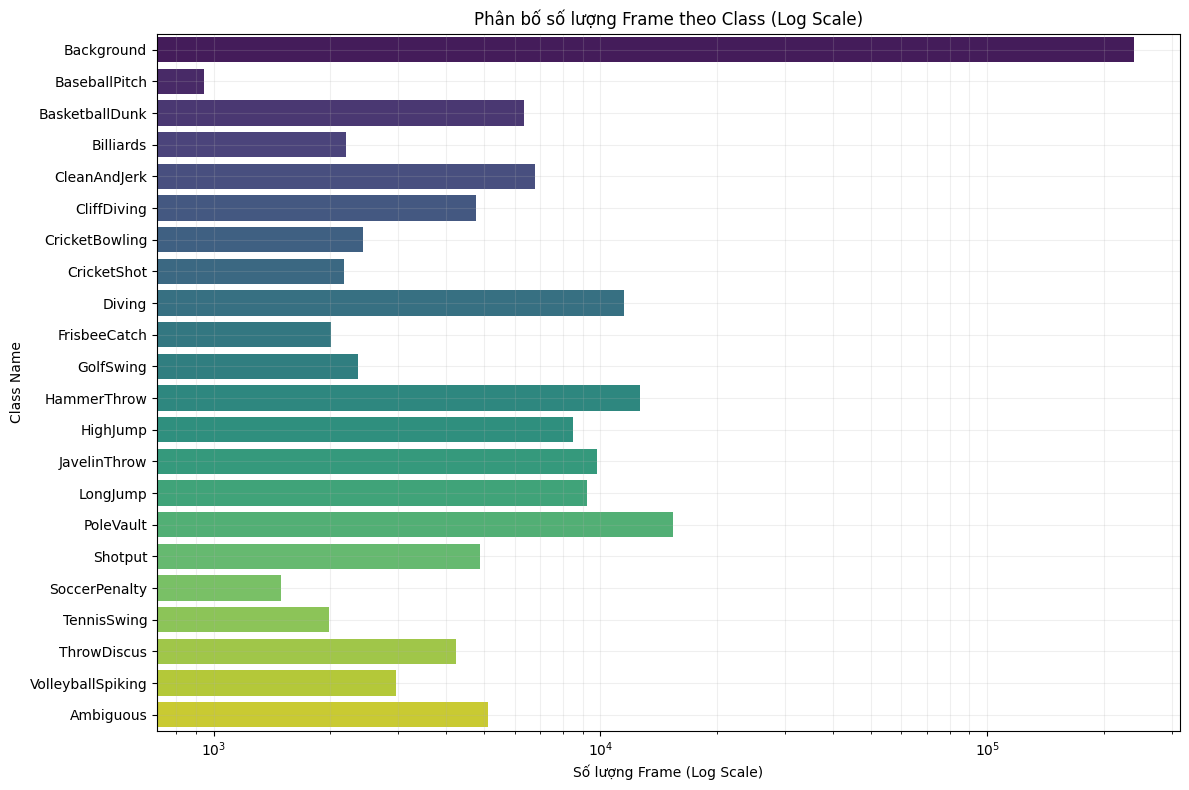

In [3]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# =============================================================================
# CẤU HÌNH
# =============================================================================
# Đường dẫn đến thư mục chứa file .npy nhãn (Target) bạn vừa tạo
LABEL_DIR = r"D:\project\DashCam\data\thumos14\target_perframe" 

# Danh sách class theo đúng thứ tự bạn cung cấp
CLASS_NAMES = [
    "Background",       # 0
    "BaseballPitch",    # 1
    "BasketballDunk",   # 2
    "Billiards",        # 3
    "CleanAndJerk",     # 4
    "CliffDiving",      # 5
    "CricketBowling",   # 6
    "CricketShot",      # 7
    "Diving",           # 8
    "FrisbeeCatch",     # 9
    "GolfSwing",        # 10
    "HammerThrow",      # 11
    "HighJump",         # 12
    "JavelinThrow",     # 13
    "LongJump",         # 14
    "PoleVault",        # 15
    "Shotput",          # 16
    "SoccerPenalty",    # 17
    "TennisSwing",      # 18
    "ThrowDiscus",      # 19
    "VolleyballSpiking",# 20
    "Ambiguous"         # 21
]

def analyze_labels(label_dir, class_names):
    npy_files = glob.glob(os.path.join(label_dir, "*.npy"))
    
    if len(npy_files) == 0:
        print(f"ERROR: Không tìm thấy file .npy nào trong {label_dir}")
        return

    num_classes = len(class_names)
    # Mảng chứa tổng số frame của mỗi class
    total_counts = np.zeros(num_classes, dtype=np.int64)
    total_frames_all = 0
    
    print(f">> Tìm thấy {len(npy_files)} files. Đang thống kê...")

    # Duyệt qua từng file
    for f_path in tqdm(npy_files):
        try:
            # Load file: Shape (N, 22)
            data = np.load(f_path)
            
            # Kiểm tra shape
            if data.ndim != 2 or data.shape[1] != num_classes:
                print(f"\n[WARNING] File {os.path.basename(f_path)} có shape lạ: {data.shape}. Bỏ qua.")
                continue
                
            # Cộng dồn theo trục dọc (axis 0) -> Ra số lượng frame có trị bằng 1 của từng class
            # Ví dụ: [1000, 5, 0, ...]
            counts = np.sum(data, axis=0)
            
            total_counts += counts.astype(np.int64)
            total_frames_all += data.shape[0]
            
        except Exception as e:
            print(f"Error loading {f_path}: {e}")

    # --- BÁO CÁO KẾT QUẢ ---
    print("\n" + "="*60)
    print(f"THỐNG KÊ DATASET (Tổng {total_frames_all} windows)")
    print("="*60)
    print(f"{'ID':<4} | {'Class Name':<20} | {'Frames':<10} | {'Ratio (%)':<10}")
    print("-" * 60)

    stats_list = []
    
    for i, name in enumerate(class_names):
        count = total_counts[i]
        ratio = (count / total_frames_all) * 100 if total_frames_all > 0 else 0
        print(f"{i:<4} | {name:<20} | {count:<10} | {ratio:<10.2f}")
        
        stats_list.append({'Class': name, 'Frames': count, 'Index': i})

    # --- CẢNH BÁO MẤT CÂN BẰNG ---
    bg_count = total_counts[0] # Giả định Background là index 0 như list bạn đưa
    action_sum = np.sum(total_counts[1:])
    
    print("="*60)
    print(f"Tổng Background (Idx 0): {bg_count}")
    print(f"Tổng Action (Idx 1-21):  {action_sum}")
    if action_sum > 0:
        print(f"Tỷ lệ BG / Action:       {bg_count / action_sum:.2f} lần")
    
    return stats_list

def plot_distribution(stats_list):
    df = pd.DataFrame(stats_list)
    
    plt.figure(figsize=(12, 8))
    # Dùng log scale vì BG thường lớn gấp trăm lần Action
    ax = sns.barplot(x='Frames', y='Class', data=df, palette='viridis')
    ax.set_xscale("log") 
    
    plt.title('Phân bố số lượng Frame theo Class (Log Scale)')
    plt.xlabel('Số lượng Frame (Log Scale)')
    plt.ylabel('Class Name')
    plt.grid(True, which="both", ls="-", alpha=0.2)
    
    # Lưu ảnh
    plt.tight_layout()
    plt.savefig('class_distribution.png')
    print("\n>> Đã lưu biểu đồ phân bố tại 'class_distribution.png'")

if __name__ == "__main__":
    stats = analyze_labels(LABEL_DIR, CLASS_NAMES)
    if stats:
        plot_distribution(stats)